In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from salt_utils import get_train_test_salt_data
from unet import UNet
import matplotlib.pyplot as plt
from dotted.collection import DottedDict
from pyfastnoisesimd import generate
import numpy as np
import pickle
import random
from random import uniform, randint
import tqdm

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  
def plot_metrics(metric_logs):
  for metric_log in metric_logs:
    plt.plot(metric_log['epoch'], metric_log['metric'], label=metric_log['label'])
  plt.xlabel('Epochs')
  plt.ylabel('Metric')
  plt.ylim(0, 5)
  plt.legend()
  plt.show()

def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()
  
def dice_loss(input, target):
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()

    return 1.0 - (((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth)))
  
def train(model, epochs=1):
  for e in tqdm.trange(epochs, desc='epochs'):
    metric = 0
    samples_seen = 0
    model.net.train()
    for img, mask in model.loader:
      model.img_cuda.copy_(img)
      del img
      model.mask_cuda.copy_(mask)
      del mask
      model.optimizer.zero_grad()
      prediction = model.net(model.img_cuda)
      loss = (F.binary_cross_entropy_with_logits(prediction, model.mask_cuda) +
              dice_loss(F.sigmoid(prediction), model.mask_cuda)) * 100
      metric += loss.item()
      samples_seen += model.batch_size
      loss.backward()
      model.optimizer.step()
      model.scheduler.step()
    model.train_metric_log['epoch'].append(model.epochs_trained)
    model.train_metric_log['metric'].append(metric / samples_seen)
    
    if model.epochs_trained % model.eval_test == 0:
      metric = 0
      samples_seen = 0
      model.net.eval()
      with torch.no_grad():
        for img, mask in model.loader_test:
          model.img_cuda.copy_(img)
          del img
          model.mask_cuda.copy_(mask)
          del mask
          prediction = model.net(model.img_cuda)
          loss = (F.binary_cross_entropy_with_logits(prediction, model.mask_cuda) +
                  dice_loss(F.sigmoid(prediction), model.mask_cuda)) * 100
          metric += loss.item()
          samples_seen += model.batch_size
      model.test_metric_log['epoch'].append(model.epochs_trained)
      model.test_metric_log['metric'].append(metric / samples_seen)
    model.epochs_trained += 1

def generate_noise():
  return fns.generate(size=[1, 128, 128], noiseType='Perlin',
                      freq=uniform(.01, .075), seed=randint(0, 100000))[0]
    
def interpolate(a, b, f):
  return (a * (1.0 - f)) + (b * f)
    
def train_mixup(model, epochs=1):
  for e in tqdm.trange(epochs, desc='epochs'):
    metric = 0
    samples_seen = 0
    model.net.train()
    for (img_a, mask_a), (img_b, mask_b) in zip(model.loader, model.loader_other):
      mixup_lerp = random.random()
      model.img_cuda.copy_(interpolate(img_a, img_b, mixup_lerp))
      del img_a; del img_b
      model.mask_cuda.copy_(interpolate(mask_a, mask_b, mixup_lerp))
      del mask_a; del mask_b
      model.optimizer.zero_grad()
      prediction = model.net(model.img_cuda)
      loss = (F.binary_cross_entropy_with_logits(prediction, model.mask_cuda) +
              dice_loss(F.sigmoid(prediction), model.mask_cuda)) * 100
      metric += loss.item()
      samples_seen += model.batch_size
      loss.backward()
      model.optimizer.step()
      model.scheduler.step()
    model.train_metric_log['epoch'].append(model.epochs_trained)
    model.train_metric_log['metric'].append(metric / samples_seen)
    
    if model.epochs_trained % model.eval_test == 0:
      metric = 0
      samples_seen = 0
      model.net.eval()
      with torch.no_grad():
        for img, mask in model.loader_test:
          model.img_cuda.copy_(img)
          del img
          model.mask_cuda.copy_(mask)
          del mask
          prediction = model.net(model.img_cuda)
          loss = (F.binary_cross_entropy_with_logits(prediction, model.mask_cuda) +
                  dice_loss(F.sigmoid(prediction), model.mask_cuda)) * 100
          metric += loss.item()
          samples_seen += model.batch_size
      model.test_metric_log['epoch'].append(model.epochs_trained)
      model.test_metric_log['metric'].append(metric / samples_seen)
    model.epochs_trained += 1
  
def weights_init(m):
  with torch.no_grad():
    if isinstance(m, nn.Conv2d):
      torch.nn.init.xavier_uniform_(m.weight)
      
def pickle_model(model, file):
  pickle.dump({
    'class': UNet,
    'trained_model': model.net.state_dict(),
    'optimizer': model.optim,
    'epochs_trained': model.epochs_trained,
    'train_metric_log': model.train_metric_log,
    'test_metric_log': model.test_metric_log,
  }, open(file, 'wb'))

In [2]:
train_data, test_data = get_train_test_salt_data('./data/train/images/', 
                                                 './data/train/masks/', 
                                                 './data/train/depths.csv', 
                                                 test_frac=.2)
model = DottedDict()
model['seed'] = 200
set_seed(model.seed)
model['batch_size'] = 48
model['net'] = UNet().cuda()
model.net.apply(weights_init)
model['optimizer'] = optim.Adam(model.net.parameters(), lr=0.025)
model['scheduler'] = optim.lr_scheduler.CosineAnnealingLR(model.optimizer, len(train_data) * 2, .0005)
model['loader'] = DataLoader(train_data, model.batch_size, True, num_workers=4, drop_last=True, pin_memory=True)
model['loader_other'] = DataLoader(train_data, model.batch_size, True, num_workers=4, drop_last=True, pin_memory=True)
model['loader_test'] = DataLoader(test_data, model.batch_size, True, num_workers=4, drop_last=True, pin_memory=True)
model['img_cuda'] = torch.empty([model.batch_size, 2, 128, 128]).cuda()
model['mask_cuda'] = torch.empty([model.batch_size, 1, 128, 128]).cuda()
model['epochs_trained'] = 0
model['eval_test'] = 1
model['train_metric_log'] = {'label':'Train Loss', 'epoch':[], 'metric':[]}
model['test_metric_log'] = {'label':'Test Loss', 'epoch':[], 'metric':[]}

In [3]:
train(model, 250)
#torch.save(model.to_python(), './models/.model')

epochs:  30%|██▉       | 74/250 [38:27<1:31:28, 31.19s/it]Process Process-596:
Process Process-594:
Process Process-593:
Process Process-595:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jasper/miniconda3/envs/torch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/jasper/miniconda3/envs/torch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/jasper/miniconda3/envs/torch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/jasper/miniconda3/envs/torch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/jasper/miniconda3/envs/torch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jasper/miniconda3/envs/torch/lib/

KeyboardInterrupt: 

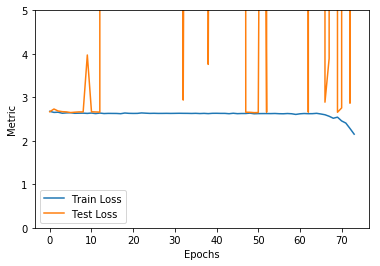

In [6]:
plot_metrics([model.train_metric_log, model.test_metric_log])